In [1]:
import pandas as pd
import zipfile
import numpy as np

#### Abaixo estamos pegando o Data Frame do Campeoanto Brasileiro de 2023, que está disponível no site [football-data-co-uk](https://www.football-data.co.uk/). Nele temos todas as partidas que ocorreram no campeonato, o resultado, e as ODDS para casa respectivo jogo. Iremos acrescentar ao Data Frame informações disponibilizadas no [transfermarket](https://www.transfermarkt.com.br/) sobre o valor dos times antes da janela de tranferência (01/09) e depois dela. Além disso, pegamos a posição de cada time no ranking feito pela [CBF](https://www.cbf.com.br/) de melhores times no Brasil nesse período, e adicionamos ao nosso Data Frame

In [2]:
df = pd.read_csv('/content/data_2023.csv')

In [3]:


# Definindo os valores de mercado antes da data de referência
valores_antes = {
    'Flamengo RJ': 153550000, 'Corinthians': 96200000, 'Sao Paulo': 85450000, 'America MG': 30500000,
    'Atletico-MG': 102250000, 'Athletico-PR': 88950000, 'Vasco': 78000000, 'Gremio': 54750000,
    'Goias': 22600000, 'Botafogo RJ': 64200000, 'Cruzeiro': 36250000, 'Coritiba': 39050000,
    'Palmeiras': 154150000, 'Santos': 81450000, 'Fluminense': 64400000, 'Fortaleza': 38750000,
    'Internacional': 67850000, 'Bahia': 55500000, 'Cuiaba': 19030000, 'Bragantino': 83000000
}

# Função para atribuir os valores
def atribuir_valores(row, coluna):
    time = row[coluna]
    if time in valores_antes and row['Date']:
        return valores_antes[time]


# Adicionando as colunas VH e VA com os valores da função acima, indo linha por linha
df['VH'] = df.apply(lambda row: atribuir_valores(row, 'Home'), axis=1)
df['VA'] = df.apply(lambda row: atribuir_valores(row, 'Away'), axis=1)


In [4]:
# Criação do dicionário de mapeamento para o ano de 2023
rank_mapping = {
        'Flamengo RJ': 1,
        'Corinthians': 8,
        'Sao Paulo': 5,
        'Bragantino': 17,
        'Atletico-MG': 4,
        'Athletico-PR': 3,
        'Gremio': 11,
        'Cuiaba': 20,
        'Cruzeiro': 18,
        'Vasco': 22,
        'Botafogo RJ': 16,
        'Fortaleza': 7,
        'Palmeiras': 2,
        'Santos': 9,
        'Fluminense': 6,
        'Goias': 19,
        'Bahia': 15,
        'America MG': 12,
        'Internacional': 10,
        'Coritiba': 23
    }

# Aplicação do mapeamento para atribuir os ranks
df['Rank_Home'] = df['Home'].map(rank_mapping)
df['Rank_Away'] = df['Away'].map(rank_mapping)

In [5]:
df

,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,...,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,VH,VA,Rank_Home,Rank_Away
0,Brazil,Serie A,2023,2023-04-15,20:00,America MG,Fluminense,0,3,A,...,2.69,3.39,2.98,2.49,3.23,2.87,30500000,64400000,12,6
1,Brazil,Serie A,2023,2023-04-15,20:00,Palmeiras,Cuiaba,2,1,H,...,1.40,5.30,9.75,1.35,4.92,8.54,154150000,19030000,2,20
2,Brazil,Serie A,2023,2023-04-15,22:30,Athletico-PR,Goias,2,0,H,...,1.67,3.75,6.75,1.62,3.57,6.17,88950000,22600000,3,19
3,Brazil,Serie A,2023,2023-04-15,22:30,Botafogo RJ,Sao Paulo,2,1,H,...,2.55,3.26,3.38,2.40,3.05,3.15,64200000,85450000,16,5
4,Brazil,Serie A,2023,2023-04-15,22:30,Bragantino,Bahia,2,1,H,...,1.91,3.80,4.58,1.84,3.56,4.21,83000000,55500000,17,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Brazil,Serie A,2023,2023-06-04,20:00,Fluminense,Bragantino,2,1,H,...,1.80,3.86,5.42,1.74,3.69,4.66,64400000,83000000,6,17
86,Brazil,Serie A,2023,2023-06-04,20:00,Gremio,Sao Paulo,2,1,H,...,2.25,3.42,4.01,2.09,3.25,3.67,54750000,85450000,11,5
87,Brazil,Serie A,2023,2023-06-04,22:30,Goias,Cuiaba,0,1,A,...,2.35,3.17,3.90,2.26,2.99,3.53,22600000,19030000,19,20
88,Brazil,Serie A,2023,2023-06-04,22:30,Palmeiras,Coritiba,3,1,H,...,1.30,6.16,14.22,1.27,5.51,11.53,154150000,39050000,2,23


#### Abaixo iremos fazer de forma diferente. O Data Frame do [transfermarket](https://www.transfermarkt.com.br/) só vai até em 2020. Então, para pegar as informações do ranking por rodada do Campeonato Brasileiro de 2023, tivemos que colocar os dados manualmente. Os dados foram extraidos do site da [CBF](https://www.cbf.com.br/)


In [6]:
# Primeiramente iremos manter o mesmo nome que foi usado nos outros anos para manter um padrão
team_name_mapping = {
    'Cruzeiro': 'Cruzeiro',
    'Internacional': 'Internacional',
    'Gremio': 'Grêmio',
    'Atletico-MG': 'Atlético-MG',
    'Bragantino': 'RB Bragantino',
    'Fluminense': 'Fluminense',
    'Corinthians': 'Corinthians',
    'Flamengo RJ': 'Flamengo',
    'Palmeiras': 'Palmeiras',
    'Fortaleza': 'Fortaleza',
    'Santos': 'Santos FC',
    'Sao Paulo': 'São Paulo',
    'Bahia': 'EC Bahia',
    'America MG': 'América-MG',
    'Athletico-PR': 'Athletico-PR',
    'Cuiaba': 'Cuiabá',
    'Goias': 'Goiás EC',
    'Vasco': 'Vasco da Gama',
    'Coritiba': 'Coritiba FC',
    'Botafogo RJ': 'Botafogo'
}


# Substituição dos nomes das equipes no dataframe
df['Home'].replace(team_name_mapping, inplace=True)
df['Away'].replace(team_name_mapping, inplace=True)

In [7]:
# Verificar os valores NaN em todo o DataFrame, para ver se tem algum dado faltante
print(df.isna().sum())

Country      0
League       0
Season       0
Date         0
Time         0
Home         0
Away         0
HG           0
AG           0
Res          0
PH           0
PD           0
PA           0
MaxH         0
MaxD         0
MaxA         0
AvgH         0
AvgD         0
AvgA         0
VH           0
VA           0
Rank_Home    0
Rank_Away    0
dtype: int64


In [8]:
# Iremos criar uma nova coluna chamada "Rodada", que muda a cada 10 partidas
df['Rodada'] = df.index // 10 + 1

# Iremos retirar as colunas abaixo (como previamente a uma partida não se tem informação da quantidade de gols,
# então iremos desconsiderar esse fator)
df.drop(['Season','Country', 'League', 'HG', 'AG'], axis=1, inplace=True)

# Iremos apenas deixar a coluna de rodadas na frente para melhorar a visualização
cols = ['Rodada'] + [col for col in df if col != 'Rodada']
df = df[cols]


In [9]:
df

,Rodada,Date,Time,Home,Away,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,VH,VA,Rank_Home,Rank_Away
0,1,2023-04-15,20:00,América-MG,Fluminense,A,2.55,3.34,2.98,2.69,3.39,2.98,2.49,3.23,2.87,30500000,64400000,12,6
1,1,2023-04-15,20:00,Palmeiras,Cuiabá,H,1.39,5.12,8.51,1.40,5.30,9.75,1.35,4.92,8.54,154150000,19030000,2,20
2,1,2023-04-15,22:30,Athletico-PR,Goiás EC,H,1.64,3.69,6.64,1.67,3.75,6.75,1.62,3.57,6.17,88950000,22600000,3,19
3,1,2023-04-15,22:30,Botafogo,São Paulo,H,2.46,3.17,3.26,2.55,3.26,3.38,2.40,3.05,3.15,64200000,85450000,16,5
4,1,2023-04-15,22:30,RB Bragantino,EC Bahia,H,1.85,3.71,4.58,1.91,3.80,4.58,1.84,3.56,4.21,83000000,55500000,17,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,9,2023-06-04,20:00,Fluminense,RB Bragantino,H,1.77,3.73,4.99,1.80,3.86,5.42,1.74,3.69,4.66,64400000,83000000,6,17
86,9,2023-06-04,20:00,Grêmio,São Paulo,H,2.09,3.32,4.01,2.25,3.42,4.01,2.09,3.25,3.67,54750000,85450000,11,5
87,9,2023-06-04,22:30,Goiás EC,Cuiabá,A,2.35,3.02,3.68,2.35,3.17,3.90,2.26,2.99,3.53,22600000,19030000,19,20
88,9,2023-06-04,22:30,Palmeiras,Coritiba FC,H,1.29,5.88,11.94,1.30,6.16,14.22,1.27,5.51,11.53,154150000,39050000,2,23


In [10]:
# Aqui pegamos manualmente posição por rodada, e iremos colocar essas informações no Data Frame
colocacao_por_rodada = {
    'Palmeiras': [7,4,3,2,2,2,2,2,2],
    'Internacional': [11,6,4,8,11,12,15,13,13],
    'Fluminense': [1,1,5,6,3,3,3,8,6],
    'Corinthians': [6,14,17,15,16,17,18,14,16],
    'Flamengo': [2,8,13,17,12,9,6,7,5],
    'Athletico-PR': [3,11,16,10,4,5,7,11,7],
    'Atlético-MG': [15,16,10,16,8,6,4,4,3],
    'Fortaleza': [10,3,2,4,6,8,11,9,9],
    'São Paulo': [14,9,8,5,7,10,8,3,8],
    'América-MG': [20,20,20,20,20,20,19,19,18],
    'Botafogo': [4,2,1,1,1,1,1,1,1],
    'Santos FC': [17,17,11,14,9,7,9,12,12],
    'Goiás EC': [18,10,15,18,18,15,16,17,17],
    'RB Bragantino': [5,7,12,12,15,13,12,10,11],
    'Coritiba FC': [19,19,19,19,19,19,20,20,20],
    'Cuiabá': [16,15,18,13,17,18,14,15,14],
    'Vasco da Gama': [8,5,9,11,14,16,17,18,19],
    'Cruzeiro': [13,12,6,3,5,4,5,6,10],
    'EC Bahia': [12,18,14,9,13,14,13,16,15],
    'Grêmio': [9,13,7,7,10,11,10,5,4]
}

def obter_colocacao(time, rodada):
    return colocacao_por_rodada[time][rodada-1]

df['colocacao_man'] = df.apply(lambda row: obter_colocacao(row['Home'], row['Rodada']), axis=1)
df['colocacao_vis'] = df.apply(lambda row: obter_colocacao(row['Away'], row['Rodada']), axis=1)


<ipython-input-10-477a8ccc3923>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['colocacao_man'] = df.apply(lambda row: obter_colocacao(row['Home'], row['Rodada']), axis=1)
<ipython-input-10-477a8ccc3923>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['colocacao_vis'] = df.apply(lambda row: obter_colocacao(row['Away'], row['Rodada']), axis=1)


In [11]:
df

,Rodada,Date,Time,Home,Away,Res,PH,PD,PA,MaxH,...,MaxA,AvgH,AvgD,AvgA,VH,VA,Rank_Home,Rank_Away,colocacao_man,colocacao_vis
0,1,2023-04-15,20:00,América-MG,Fluminense,A,2.55,3.34,2.98,2.69,...,2.98,2.49,3.23,2.87,30500000,64400000,12,6,20,1
1,1,2023-04-15,20:00,Palmeiras,Cuiabá,H,1.39,5.12,8.51,1.40,...,9.75,1.35,4.92,8.54,154150000,19030000,2,20,7,16
2,1,2023-04-15,22:30,Athletico-PR,Goiás EC,H,1.64,3.69,6.64,1.67,...,6.75,1.62,3.57,6.17,88950000,22600000,3,19,3,18
3,1,2023-04-15,22:30,Botafogo,São Paulo,H,2.46,3.17,3.26,2.55,...,3.38,2.40,3.05,3.15,64200000,85450000,16,5,4,14
4,1,2023-04-15,22:30,RB Bragantino,EC Bahia,H,1.85,3.71,4.58,1.91,...,4.58,1.84,3.56,4.21,83000000,55500000,17,15,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,9,2023-06-04,20:00,Fluminense,RB Bragantino,H,1.77,3.73,4.99,1.80,...,5.42,1.74,3.69,4.66,64400000,83000000,6,17,6,11
86,9,2023-06-04,20:00,Grêmio,São Paulo,H,2.09,3.32,4.01,2.25,...,4.01,2.09,3.25,3.67,54750000,85450000,11,5,4,8
87,9,2023-06-04,22:30,Goiás EC,Cuiabá,A,2.35,3.02,3.68,2.35,...,3.90,2.26,2.99,3.53,22600000,19030000,19,20,17,14
88,9,2023-06-04,22:30,Palmeiras,Coritiba FC,H,1.29,5.88,11.94,1.30,...,14.22,1.27,5.51,11.53,154150000,39050000,2,23,2,20


#### Abaixo iremos adicionar 4 novas colunas. No Data Frame não está sendo considerado um fator julgado como importante que seria o "momento" do time. Para considerar isso, foi pensado em analisar as últimas X partidas disputadas e ver a quantidade de pontos convertidos nas X últimas partidas. Basicamente está sendo analisado a porcentagem de pontos feitos nas últimas partidas ((pontos convertidos/pontos totais) considerando as últimas X partidas). Então nas primerias 2 colunas, está considerando a porcentagem de partidas do time Home e Away, analisando todas as partidas, independente de estar jogando dentro ou fora de casa. Já nas outras 2 colunas, está sendo considerado a porcentagem de pontos convertidos do time Home jogando as X últimas partidas como mandante, e na outra a porcentagem de pontos convertidos do time Away jogando as últimas X partidas como visitante. Porém, para as primeiras X partidas, como não tem informação do histórico, foi colocado um valor padrão de 50%.

In [12]:
# Lógica para colocar as 2 colunas das partidas gerais

# Supondo que 'df' seja o seu DataFrame
X = 5
df['Date'] = pd.to_datetime(df['Date'])  # Certificar-se de que a data está no formato correto

# Vamos mapear os resultados para pontos
result_points_mapping = {'H': [3, 0], 'D': [1, 1], 'A': [0, 3]}
df[['Home_points', 'Away_points']] = df['Res'].apply(lambda res: pd.Series(result_points_mapping[res]))

# Criamos DataFrames separados para Home e Away
df_home = df[['Date', 'Home', 'Home_points']].rename(columns={'Home': 'Team', 'Home_points': 'Points'})
df_away = df[['Date', 'Away', 'Away_points']].rename(columns={'Away': 'Team', 'Away_points': 'Points'})

# Concatenamos e ordenamos por time e data
df_points = pd.concat([df_home, df_away]).sort_values(['Team', 'Date'])

# Calculamos a média dos últimos X jogos
df_points['Last_X_Pts_Ratio'] = df_points.groupby('Team')['Points'].rolling(X, min_periods=1).sum().reset_index(0,drop=True) / (3*X)

# Então, atribuímos 50% para as primeiras X partidas
df_points['Last_X_Pts_Ratio'] = df_points.groupby('Team')['Last_X_Pts_Ratio'].apply(lambda x: x.shift().fillna(0.5))

# Finalmente, unimos de volta ao DataFrame original
df_points = df_points[['Date', 'Team', 'Last_X_Pts_Ratio']]

# Na operação de união, inclua apenas as colunas necessárias
df = df.merge(df_points, how='left', left_on=['Date', 'Home'], right_on=['Date', 'Team']).rename(columns={'Last_X_Pts_Ratio': 'Last_X_Pts_Ratio_Home'})
df = df.merge(df_points, how='left', left_on=['Date', 'Away'], right_on=['Date', 'Team']).rename(columns={'Last_X_Pts_Ratio': 'Last_X_Pts_Ratio_Away'})


<ipython-input-12-fa3500e0c79c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])  # Certificar-se de que a data está no formato correto
<ipython-input-12-fa3500e0c79c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Home_points', 'Away_points']] = df['Res'].apply(lambda res: pd.Series(result_points_mapping[res]))
<ipython-input-12-fa3500e0c79c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [13]:
# Para o time da casa
df_home = df[['Date', 'Home', 'Home_points']].copy()
df_home['Last_X_Home_Pts_Ratio'] = df_home.groupby('Home')['Home_points'].rolling(X, min_periods=1).sum().reset_index(0,drop=True) / (3*X)
df_home['Last_X_Home_Pts_Ratio'] = df_home.groupby('Home')['Last_X_Home_Pts_Ratio'].apply(lambda x: x.shift().fillna(0.5))
df_home = df_home[['Date', 'Home', 'Last_X_Home_Pts_Ratio']]
# Na operação de união, inclua apenas as colunas necessárias
df = df.merge(df_home, how='left', on=['Date', 'Home'])

# Para o time visitante
df_away = df[['Date', 'Away', 'Away_points']].copy()
df_away['Last_X_Away_Pts_Ratio'] = df_away.groupby('Away')['Away_points'].rolling(X, min_periods=1).sum().reset_index(0,drop=True) / (3*X)
df_away['Last_X_Away_Pts_Ratio'] = df_away.groupby('Away')['Last_X_Away_Pts_Ratio'].apply(lambda x: x.shift().fillna(0.5))
df_away = df_away[['Date', 'Away', 'Last_X_Away_Pts_Ratio']]

# Na operação de união, inclua apenas as colunas necessárias
df = df.merge(df_away, how='left', on=['Date', 'Away'])


<ipython-input-13-07d7d8166e40>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_home['Last_X_Home_Pts_Ratio'] = df_home.groupby('Home')['Last_X_Home_Pts_Ratio'].apply(lambda x: x.shift().fillna(0.5))
<ipython-input-13-07d7d8166e40>:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_away['L

In [14]:
# Analisar para ver se todos os dados foram preenchidos corretamente
print(df.columns)
df.drop(['Home_points','Away_points', 'Team_x', 'Team_y'], axis=1, inplace=True)

Index(['Rodada', 'Date', 'Time', 'Home', 'Away', 'Res', 'PH', 'PD', 'PA',
       'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'VH', 'VA', 'Rank_Home',
       'Rank_Away', 'colocacao_man', 'colocacao_vis', 'Home_points',
       'Away_points', 'Team_x', 'Last_X_Pts_Ratio_Home', 'Team_y',
       'Last_X_Pts_Ratio_Away', 'Last_X_Home_Pts_Ratio',
       'Last_X_Away_Pts_Ratio'],
      dtype='object')


In [15]:
df

,Rodada,Date,Time,Home,Away,Res,PH,PD,PA,MaxH,...,VH,VA,Rank_Home,Rank_Away,colocacao_man,colocacao_vis,Last_X_Pts_Ratio_Home,Last_X_Pts_Ratio_Away,Last_X_Home_Pts_Ratio,Last_X_Away_Pts_Ratio
0,1,2023-04-15,20:00,América-MG,Fluminense,A,2.55,3.34,2.98,2.69,...,30500000,64400000,12,6,20,1,0.500000,0.500000,0.500000,0.500000
1,1,2023-04-15,20:00,Palmeiras,Cuiabá,H,1.39,5.12,8.51,1.40,...,154150000,19030000,2,20,7,16,0.500000,0.500000,0.500000,0.500000
2,1,2023-04-15,22:30,Athletico-PR,Goiás EC,H,1.64,3.69,6.64,1.67,...,88950000,22600000,3,19,3,18,0.500000,0.500000,0.500000,0.500000
3,1,2023-04-15,22:30,Botafogo,São Paulo,H,2.46,3.17,3.26,2.55,...,64200000,85450000,16,5,4,14,0.500000,0.500000,0.500000,0.500000
4,1,2023-04-15,22:30,RB Bragantino,EC Bahia,H,1.85,3.71,4.58,1.91,...,83000000,55500000,17,15,5,12,0.500000,0.500000,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,9,2023-06-04,20:00,Fluminense,RB Bragantino,H,1.77,3.73,4.99,1.80,...,64400000,83000000,6,17,6,11,0.466667,0.600000,0.466667,0.200000
86,9,2023-06-04,20:00,Grêmio,São Paulo,H,2.09,3.32,4.01,2.25,...,54750000,85450000,11,5,4,8,0.533333,0.733333,0.533333,0.200000
87,9,2023-06-04,22:30,Goiás EC,Cuiabá,A,2.35,3.02,3.68,2.35,...,22600000,19030000,19,20,17,14,0.266667,0.466667,0.400000,0.400000
88,9,2023-06-04,22:30,Palmeiras,Coritiba FC,H,1.29,5.88,11.94,1.30,...,154150000,39050000,2,23,2,20,0.600000,0.133333,0.666667,0.066667


In [16]:
# Configurando 'Date' como índice
df.set_index('Date', inplace=True)

# Ordenando o DataFrame por data
df.sort_index(inplace=True)


#### Abaixo estamos separando o Data Frame geral, que temos cada linha sendo uma partida com todos os times, em Data Frames inidividuais, sendo cada Data Frame um time em específico. Então separamos o Data Frame de 380 linhas com 20 times, em 20 Data Frames, cada um com 38 linhas, que são as 38 partidas disputadas por cada equipe através do campeonato

In [17]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Res_encoded'] = encoder.fit_transform(df['Res'])

# Criar uma lista única de todos os times presentes no DataFrame
all_teams = pd.unique(df['Home'].values.ravel())

# Criar um dicionário para armazenar os DataFrames de cada time
team_dfs = {}

# Iterar sobre cada time e criar um DataFrame separado para cada um
for team in all_teams:
    # Selecionar as partidas em que o time é o mandante ou visitante
    team_games = df[(df['Home'] == team) | (df['Away'] == team)]

    # Armazenar o DataFrame do time no dicionário
    team_dfs[team] = team_games


In [18]:
"""
Como estaremos tratando problemas de séries temporais então é necessário
ordenar por tempo, então primeiramente iremos ordenar todos os data frames
por data
"""
for team in all_teams:
    team_dfs[team] = team_dfs[team].sort_values('Date')


Este é um código para treinar um modelo usando PyTorch. O processo de treinamento é dividido em várias épocas, que são iterações completas através do conjunto de treinamento.

Dentro de cada época, os dados são processados em lotes para otimizar o uso de memória e acelerar o treinamento. Cada lote é processado da seguinte forma:

Primeiro, uma janela dos dados é selecionada e os recursos são extraídos e transformados em tensores do PyTorch.
O modelo é então usado para fazer previsões nos recursos da janela.
As previsões do modelo são processadas com a função softmax para calcular as probabilidades para cada classe.
A entropia dessas probabilidades é então calculada. A entropia é uma medida de incerteza. Quanto maior a entropia, mais incerta é a previsão.
Se a entropia for maior do que um limite pré-determinado (neste caso, 0,5), a perda é calculada para essas previsões e os gradientes são retropropagados através da rede. Isso significa que o modelo é treinado apenas em amostras onde está incerto em suas previsões.
O otimizador é então usado para atualizar os pesos do modelo.
O modelo é então avaliado em um conjunto de teste. O desempenho é avaliado calculando a perda nos dados de teste e a acurácia balanceada, que é uma métrica que leva em conta o desbalanceamento do conjunto de dados.

Finalmente, o modelo com a melhor acurácia balanceada é salvo. Isso permite que você retome o treinamento de onde parou ou use o melhor modelo para fazer previsões posteriormente.

Também há um critério de parada antecipada implementado para parar o treinamento se a perda de validação não melhorar após um determinado número de épocas. Isso pode ajudar a prevenir o sobreajuste.

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split

# Definindo os conjuntos de treino e teste com 70% para treino e 30% para teste
train_df1, test_df1 = train_test_split(df, test_size=0.3, random_state=42)

# Imprime o número de linhas em cada DataFrame
print("Number of rows in train_df: ", train_df1.shape[0])
print("Number of rows in test_df: ", test_df1.shape[0])
# Imprime o número de linhas presentes nos dataframes de treinamento e teste.


Number of rows in train_df:  63
Number of rows in test_df:  27


In [20]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.nn.functional as F

# Definindo a estrutura do modelo
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(57, 128)  # Primeira camada totalmente conectada
        self.dropout1 = nn.Dropout(0.4)  # Dropout após a primeira camada com taxa de desligamento de 50%
        self.fc2 = nn.Linear(128, 64)  # Segunda camada totalmente conectada
        self.dropout2 = nn.Dropout(0.4)  # Dropout após a segunda camada com taxa de desligamento de 50%
        self.fc3 = nn.Linear(64, 3)  # Terceira camada totalmente conectada

    def forward(self, x):
        x = x.reshape(-1, 57)  # Redimensionando a entrada
        x = torch.tanh(self.fc1(x))  # Passando a entrada pela primeira camada e aplicando a função de ativação tanh
        x = self.dropout1(x)  # Aplicação do dropout após a primeira camada
        x = torch.tanh(self.fc2(x))  # Passando a saída da primeira camada pela segunda camada e aplicando a função de ativação tanh
        x = self.dropout2(x)  # Aplicação do dropout após a segunda camada
        x = self.fc3(x)  # Passando a saída da segunda camada pela terceira camada
        return x

In [21]:
# Lista das colunas de características e da coluna alvo
feature_columns = ['PH', 'PD', 'PA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'VH', 'VA', 'Rank_Home', 'Rank_Away', 'colocacao_man', 'colocacao_vis', 'Last_X_Pts_Ratio_Home', 'Last_X_Pts_Ratio_Away', 'Last_X_Home_Pts_Ratio', 'Last_X_Away_Pts_Ratio']
target_column = 'Res_encoded'

# Pesos de cada classe para lidar com o desequilíbrio de classes
weights = torch.tensor([1.25, 1.25, 0.6])

# Inicializando o modelo MLP
model = MLP()
# Definindo a função de perda - a entropia cruzada é utilizada para problemas de classificação
loss_function = nn.CrossEntropyLoss(weight=weights)
# Definindo o otimizador - Adam é um algoritmo de otimização popular
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)

# Define o tamanho da janela
window_size = 3


In [22]:
# Função para calcular a entropia
def entropy(x):
    return (torch.sum(x * torch.log2(x+0.00000000000001), dim=1))*-1

In [23]:
import random
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

# Define uma semente para garantir a reprodutibilidade do código
randomseed = 42
torch.manual_seed(randomseed);
torch.cuda.manual_seed_all(randomseed);
random.seed(randomseed);
np.random.seed(randomseed)
torch.backends.cudnn.deterministic=True


# Cria um objeto StandardScaler para normalizar os dados
scaler = StandardScaler()

# Ajusta o normalizador aos dados de treinamento (calcula a média e o desvio padrão)
scaler.fit(train_df1[feature_columns])

# Usa o normalizador para transformar os dados de treinamento e validação
train_df1[feature_columns] = scaler.transform(train_df1[feature_columns])
test_df1[feature_columns] = scaler.transform(test_df1[feature_columns])

# Define o número de épocas
num_epochs = 100

# Inicia a paciência para o Early Stopping
patience = 0
patience_limit = 100  # Define um limite para a paciência

# Cria listas para armazenar as perdas de treinamento e validação
train_losses = []
val_losses = []

# Inicializa a melhor acurácia balanceada
best_bal_acc = 0

# Inicializa a melhor perda de validação
best_val_loss = float('inf')

# Define o tamanho do lote de treinamento e teste
train_batch_size = 32
test_batch_size = 16

In [24]:
# Loop sobre o número de épocas
for epoch in range(num_epochs):
    # Parte de treinamento
    running_train_loss = 0.0
    for i in range(0, len(train_df1), train_batch_size):  # Iterando sobre o conjunto de treinamento em lotes
        for j in range(i, min(i + train_batch_size, len(train_df1)) - window_size):  # Iterando sobre cada lote

            # Aqui, criamos os lotes de treinamento usando o tamanho da janela definido
            train_batch = train_df1.iloc[j:j+window_size]
            train_features = torch.tensor(train_batch[feature_columns].values, dtype=torch.float)
            train_targets = torch.tensor(train_df1[target_column].iloc[j + window_size], dtype=torch.long).unsqueeze(0)

            # Obtém os outputs do modelo
            outputs = model(train_features)

            # Obtém as probabilidades aplicando softmax
            probs = torch.softmax(outputs, dim=1)

            # Calcula a entropia
            ent = entropy(probs)

            # Define um limite para a entropia
            entropy_threshold = 0.5

            # Seleciona apenas os outputs e targets onde a entropia é maior que o limite
            indices = torch.where(ent > entropy_threshold)
            high_entropy_outputs = outputs[indices]
            high_entropy_targets = train_targets[indices]

            # Zera os gradientes do otimizador
            optimizer.zero_grad()

            # Calcula a loss apenas para essas amostras
            loss = loss_function(high_entropy_outputs, high_entropy_targets)

            # Retropropagação do erro
            loss.backward()

            # Atualiza os parâmetros do modelo
            optimizer.step()

            # Adicione a perda atual ao running_train_loss
            running_train_loss += loss.item()

    # Adicione a perda média de treinamento à lista train_losses
    train_losses.append(running_train_loss / (len(train_df1) // 10))

    # Parte de teste
    all_predictions = []
    all_true_values = []
    running_val_loss = 0.0
    for i in range(0, len(test_df1), test_batch_size):  # Iterando sobre o conjunto de teste em lotes
        if i + test_batch_size < len(test_df1):  # Garantindo que não vamos além do tamanho do dataframe de teste
            for j in range(i + test_batch_size, min(i + 2 * test_batch_size, len(test_df1)) - window_size):  # Iterando sobre cada lote

                # Aqui, estamos usando o conjunto de teste
                test_batch = test_df1.iloc[j:j+window_size]
                test_features = torch.tensor(test_batch[feature_columns].values, dtype=torch.float)
                test_targets = torch.tensor(test_df1[target_column].iloc[j + window_size], dtype=torch.long).unsqueeze(0)

                with torch.no_grad():  # Não precisamos calcular gradientes durante a fase de teste
                    outputs = model(test_features)
                    loss = loss_function(outputs, test_targets)
                    _, predicted = torch.max(outputs.data, 1)

                # Adicione a perda atual ao running_val_loss
                running_val_loss += loss.item()

                all_predictions.extend(predicted.numpy())
                all_true_values.extend(test_targets.numpy())

    # Adicione a perda média de validação à lista val_losses
    val_loss = running_val_loss / len(test_df1)
    val_losses.append(val_loss)

    # Calcula a acurácia balanceada no conjunto de validação
    bal_acc = balanced_accuracy_score(all_true_values, all_predictions)

    # Verificando se a acurácia balanceada atual é a melhor
    if bal_acc > best_bal_acc:
        best_bal_acc = bal_acc
        # Salva o modelo com a maior acurácia balanceada
        torch.save(model.state_dict(), "best_model.pth")

    # Verificando se a perda de validação atual é a melhor
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Reset a paciência
        patience += 0
    else:
        patience += 1

    # Interrompe o treinamento se a paciência for maior que o limite de paciência
    if patience >= patience_limit:
        print("Early stopping at epoch: ", epoch)
        break

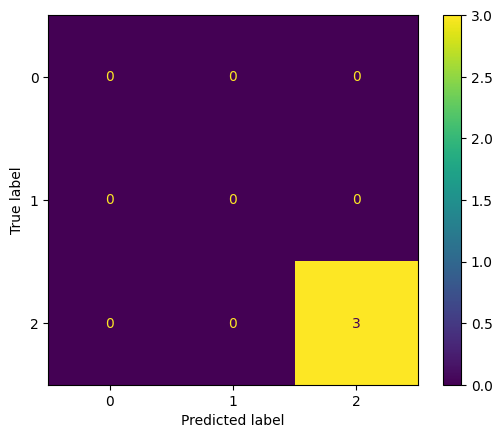

,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score
0,1.0,1.0,1.0,1.0,1.0


In [25]:
# Importa as bibliotecas necessárias para avaliar o modelo
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Carrega o melhor modelo salvo durante o treinamento
model = MLP()
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Coloca o modelo no modo de avaliação

# Tamanho do lote de teste
test_batch_size = 16

all_predictions = []
all_true_values = []

# Faz previsões no conjunto de teste
for i in range(0, len(test_df1), test_batch_size):
    if i + 10 < len(test_df1):
        for j in range(i+10, min(i+test_batch_size, len(test_df1))-window_size):

            # Seleciona uma janela de exemplos de teste
            test_batch = test_df1.iloc[j:j+window_size]

            # Converte os exemplos para tensores do PyTorch
            test_features = torch.tensor(test_batch[feature_columns].values, dtype=torch.float)
            test_targets = torch.tensor(test_df1[target_column].iloc[j + window_size], dtype=torch.long).unsqueeze(0)

            # Faz previsões com o modelo
            with torch.no_grad():
                outputs = model(test_features)

            # Obtém as classes preditas
            _, predicted = torch.max(outputs.data, 1)

            # Adiciona as predições e os verdadeiros valores às listas correspondentes
            all_predictions.extend(predicted.numpy())
            all_true_values.extend(test_targets.numpy())

# Calcula as métricas do modelo
conf_matrix = confusion_matrix(y_true=all_true_values, y_pred=all_predictions, labels=[0, 1, 2])
accuracy = accuracy_score(all_true_values, all_predictions)
balanced_accuracy = balanced_accuracy_score(all_true_values, all_predictions)
precision = precision_score(all_true_values, all_predictions, average='weighted')
recall = recall_score(all_true_values, all_predictions, average='weighted')
f1 = f1_score(all_true_values, all_predictions, average='weighted')

# Cria um dataframe para exibir as métricas
metrics_df = pd.DataFrame({"Accuracy": [accuracy],
                           "Balanced Accuracy": [balanced_accuracy],
                           "Precision": [precision],
                           "Recall": [recall],
                           "F1 Score": [f1]})

# Plota a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

# Exibe o dataframe com as métricas
metrics_df

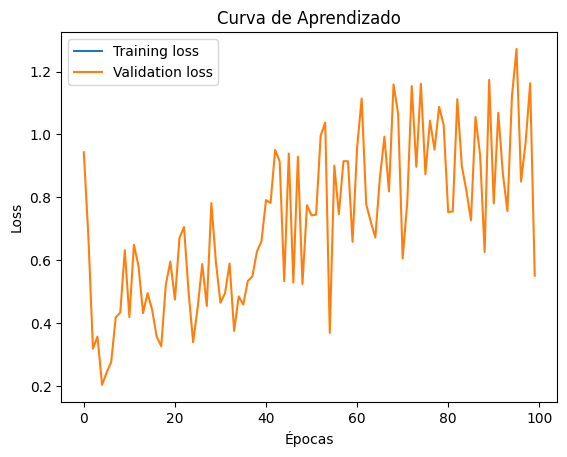

In [26]:
# Exemplo de como plotar a curva de aprendizado
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Curva de Aprendizado')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()


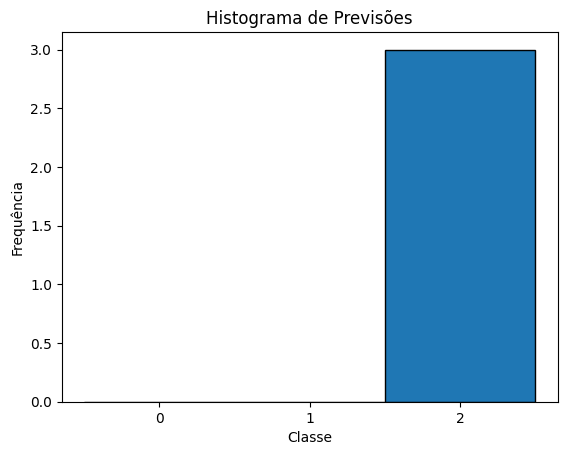

In [27]:
# Exemplo de como plotar um histograma de previsões
plt.figure()
plt.hist(all_predictions, bins=np.arange(4) - 0.5, edgecolor='black')
plt.title('Histograma de Previsões')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.xticks([0, 1, 2])
plt.show()


Processing team: América-MG


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


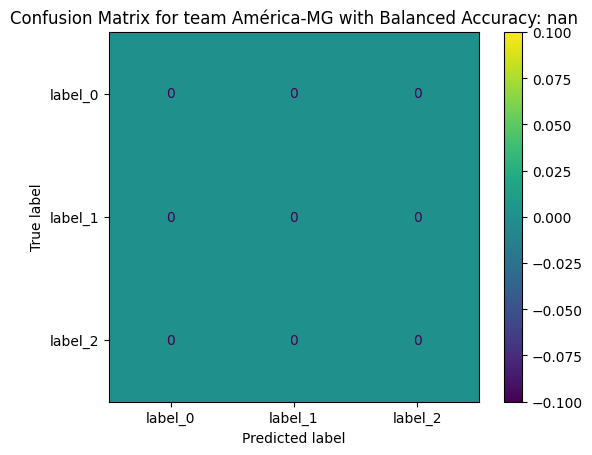

Processing team: Palmeiras


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


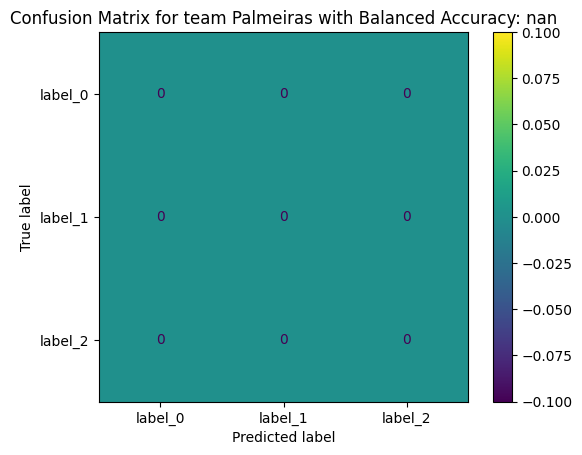

Processing team: Athletico-PR


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


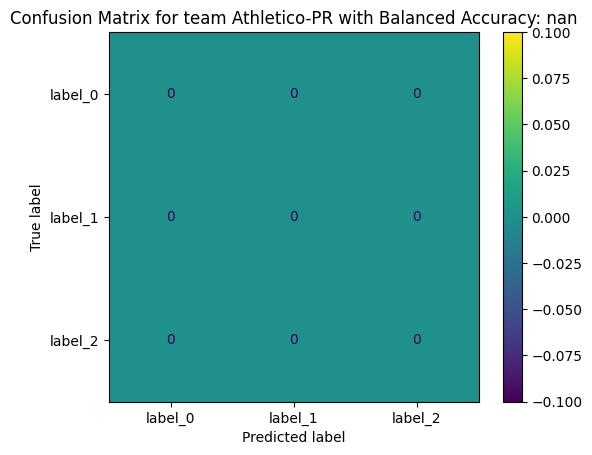

Processing team: Botafogo


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


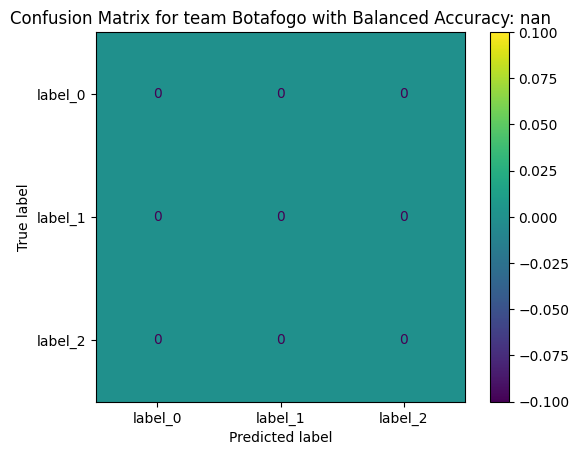

Processing team: RB Bragantino


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


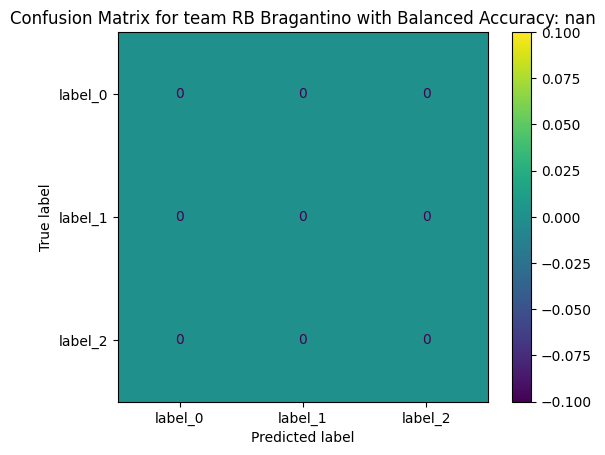

Processing team: Fortaleza


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


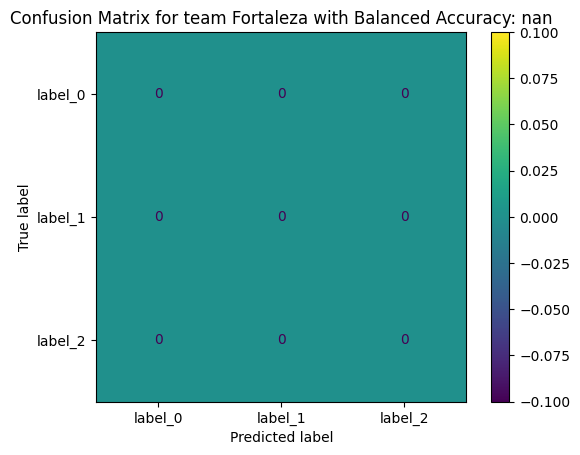

Processing team: Atlético-MG


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


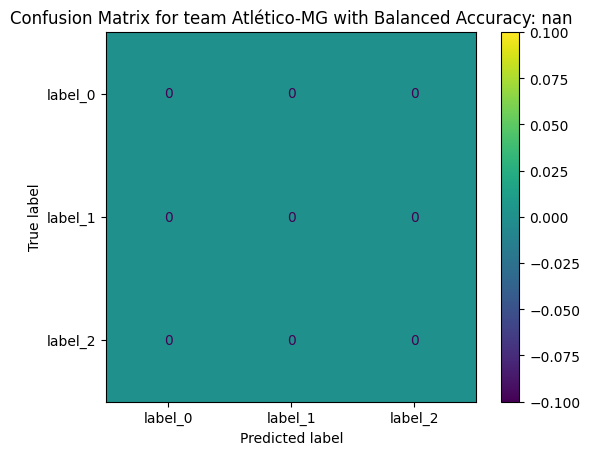

Processing team: Corinthians


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


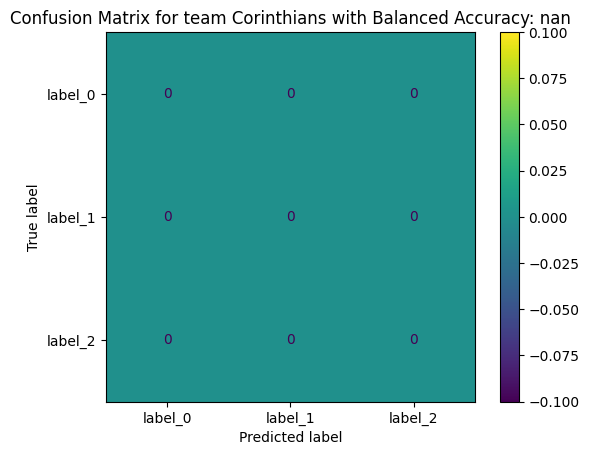

Processing team: Flamengo


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


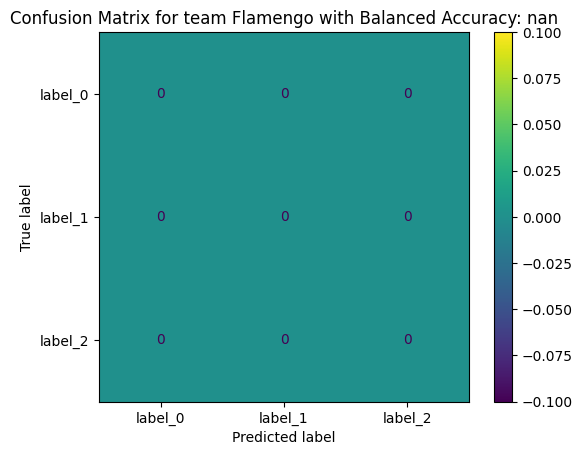

Processing team: Grêmio


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


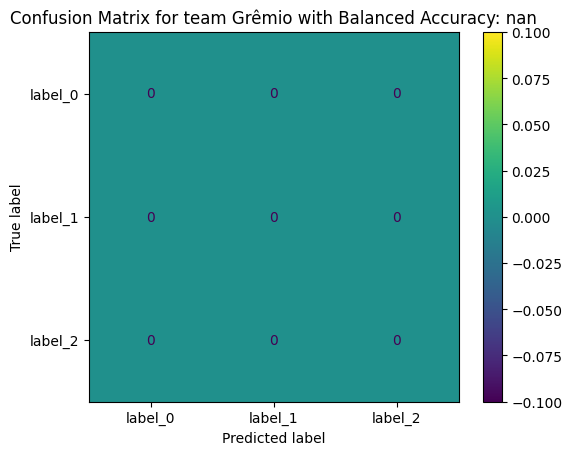

Processing team: Fluminense


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


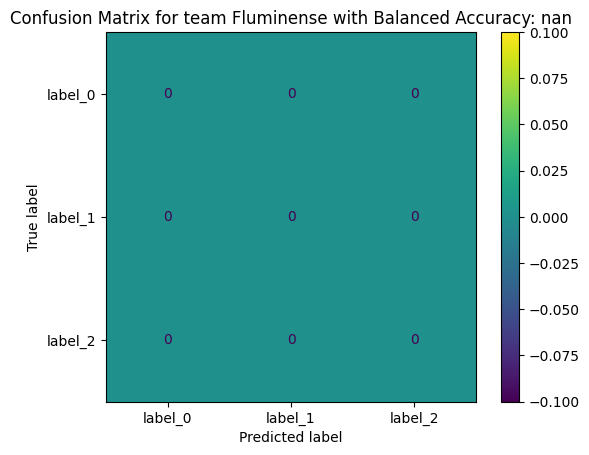

Processing team: Cuiabá


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


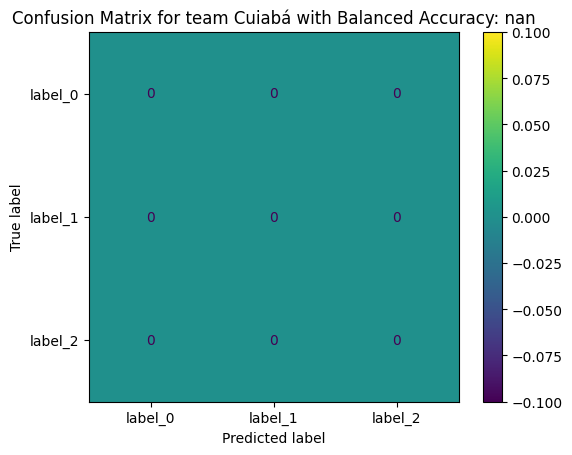

Processing team: São Paulo


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


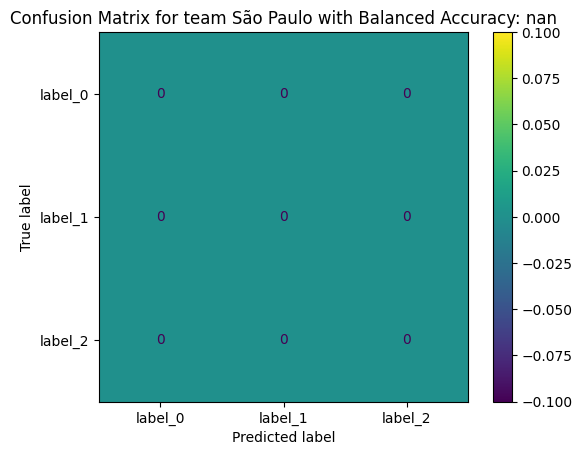

Processing team: Cruzeiro


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


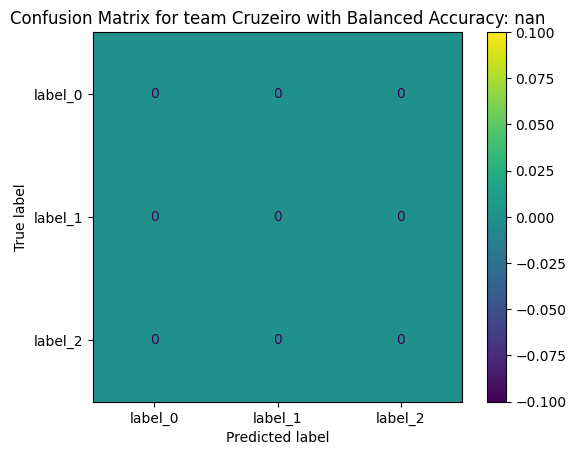

Processing team: Internacional


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


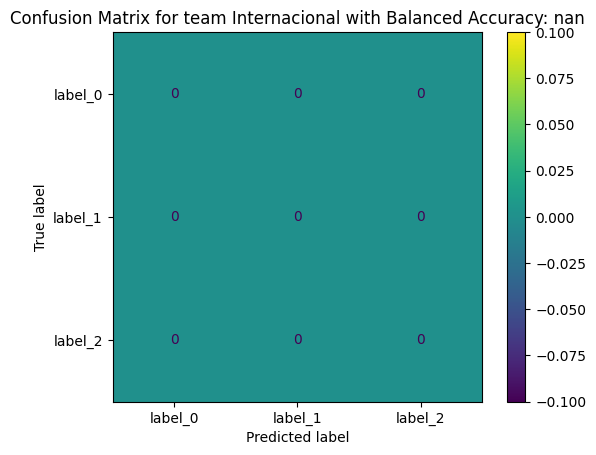

Processing team: Santos FC


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


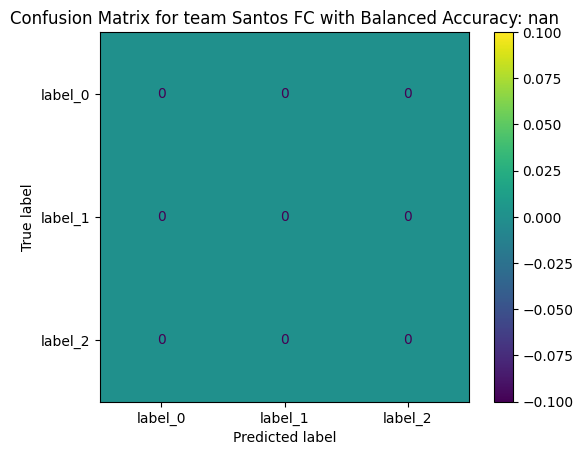

Processing team: Vasco da Gama


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


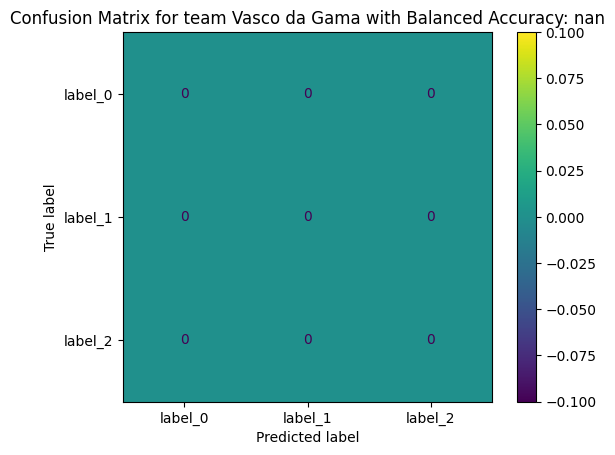

Processing team: Coritiba FC


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


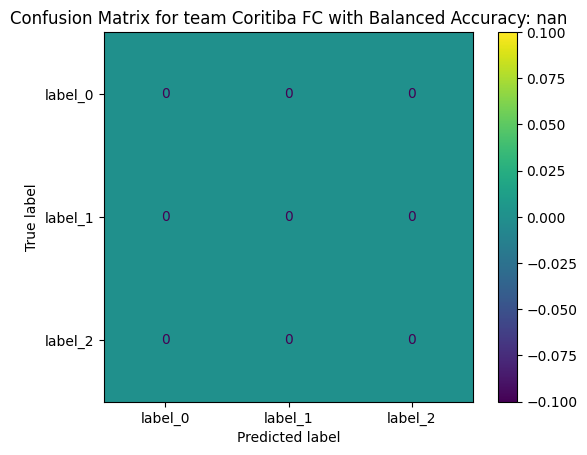

Processing team: Goiás EC


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


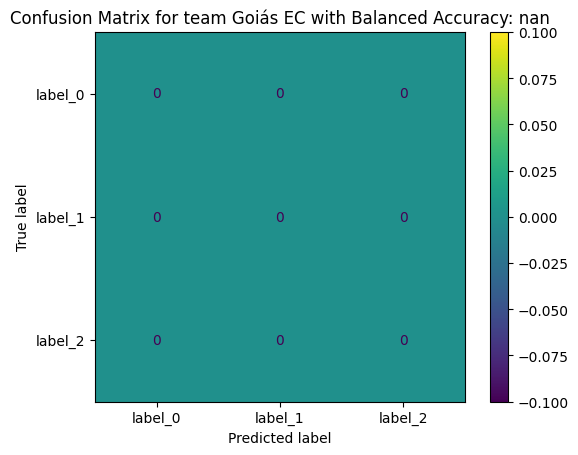

Processing team: EC Bahia


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


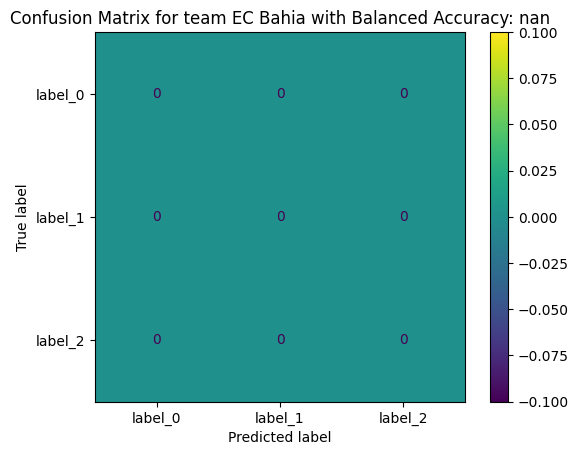

In [28]:
from sklearn.metrics import balanced_accuracy_score

# Carrega o melhor modelo salvo durante o treinamento
model = MLP()
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Coloca o modelo no modo de avaliação

# Itera sobre cada time
for team in all_teams:
    print(f"Processing team: {team}")

    # Obtém os dados do time
    team_train_df = team_dfs[team]
    team_test_df = team_dfs[team]

    # Normaliza os dados
    scaler = StandardScaler()
    scaler.fit(team_train_df[feature_columns])
    team_train_df[feature_columns] = scaler.transform(team_train_df[feature_columns])
    team_test_df[feature_columns] = scaler.transform(team_test_df[feature_columns])

    # Avalia o modelo
    all_predictions = []
    all_true_values = []
    for i in range(0, len(team_test_df), test_batch_size):
        if i + 10 < len(team_test_df):
            for j in range(i+10, min(i+test_batch_size, len(team_test_df))-window_size):

                # Seleciona uma janela de exemplos de teste
                test_batch = team_test_df.iloc[j:j+window_size]

                # Converte os exemplos para tensores do PyTorch
                test_features = torch.tensor(test_batch[feature_columns].values, dtype=torch.float)
                test_targets = torch.tensor(team_test_df[target_column].iloc[j + window_size], dtype=torch.long).unsqueeze(0)

                # Faz previsões com o modelo
                with torch.no_grad():
                    outputs = model(test_features)

                # Obtém as classes preditas
                _, predicted = torch.max(outputs.data, 1)

                # Adiciona as predições e os verdadeiros valores às listas correspondentes
                all_predictions.extend(predicted.numpy())
                all_true_values.extend(test_targets.numpy())

    # Calcula a acurácia balanceada
    balanced_accuracy = balanced_accuracy_score(all_true_values, all_predictions)

    # Calcula a matriz de confusão
    conf_matrix = confusion_matrix(y_true=all_true_values, y_pred=all_predictions, labels=[0, 1, 2])

    # Plota a matriz de confusão
    title = f"Confusion Matrix for team {team} with Balanced Accuracy: {balanced_accuracy:.2f}"
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['label_0', 'label_1', 'label_2'])
    disp.plot()
    plt.title(title)
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

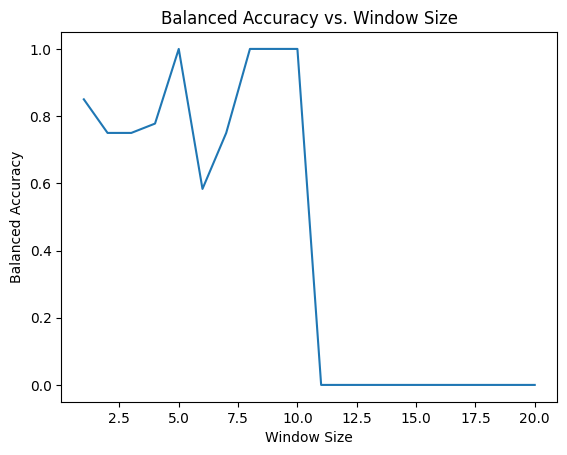

In [29]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Lista para armazenar acurácia balanceada para cada tamanho de janela
window_sizes = list(range(1, 21))  # Experimenta janelas de tamanho de 1 a 20
balanced_accuracies = []

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = x.reshape(-1, input_size)  # Redimensionando a entrada
        x = torch.tanh(self.fc1(x))
        x = self.dropout1(x)
        x = torch.tanh(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

for window_size in window_sizes:
    input_size = len(feature_columns) * window_size
    model = MLP(input_size)
    # Define uma semente para garantir a reprodutibilidade do código
    randomseed = 42
    torch.manual_seed(randomseed);
    torch.cuda.manual_seed_all(randomseed);
    random.seed(randomseed);
    np.random.seed(randomseed)
    torch.backends.cudnn.deterministic=True


    # Cria um objeto StandardScaler para normalizar os dados
    scaler = StandardScaler()

    # Ajusta o normalizador aos dados de treinamento (calcula a média e o desvio padrão)
    scaler.fit(train_df1[feature_columns])

    # Usa o normalizador para transformar os dados de treinamento e validação
    train_df1[feature_columns] = scaler.transform(train_df1[feature_columns])
    test_df1[feature_columns] = scaler.transform(test_df1[feature_columns])

    # Define o número de épocas
    num_epochs = 100

    # Inicia a paciência para o Early Stopping
    patience = 0
    patience_limit = 100  # Define um limite para a paciência

    # Cria listas para armazenar as perdas de treinamento e validação
    train_losses = []
    val_losses = []

    # Inicializa a melhor acurácia balanceada
    best_bal_acc = 0

    # Inicializa a melhor perda de validação
    best_val_loss = float('inf')

    # Define o tamanho do lote de treinamento e teste
    train_batch_size = 32
    test_batch_size = 16

    # Inicia a paciência para o Early Stopping
    patience = 0
    patience_limit = 100  # Define um limite para a paciência

    # Cria listas para armazenar as perdas de treinamento e validação
    train_losses = []
    val_losses = []

    # Inicializa a melhor acurácia balanceada
    best_bal_acc = 0

    # Inicializa a melhor perda de validação
    best_val_loss = float('inf')

    # Define o tamanho do lote de treinamento e teste
    train_batch_size = 32
    test_batch_size = 16

    # Loop sobre o número de épocas
    for epoch in range(num_epochs):
        # Parte de treinamento
        running_train_loss = 0.0
        for i in range(0, len(train_df1), train_batch_size):  # Iterando sobre o conjunto de treinamento em lotes
            for j in range(i, min(i + train_batch_size, len(train_df1)) - window_size):  # Iterando sobre cada lote

                train_batch = train_df1.iloc[j:j+window_size]
                train_features = torch.tensor(train_batch[feature_columns].values.flatten(), dtype=torch.float)
                train_targets = torch.tensor(train_df1[target_column].iloc[j + window_size], dtype=torch.long).unsqueeze(0)

                # Obtém os outputs do modelo
                outputs = model(train_features)

                # Obtém as probabilidades aplicando softmax
                probs = torch.softmax(outputs, dim=1)

                # Calcula a entropia
                ent = entropy(probs)

                # Define um limite para a entropia
                entropy_threshold = 0.5

                # Seleciona apenas os outputs e targets onde a entropia é maior que o limite
                indices = torch.where(ent > entropy_threshold)
                high_entropy_outputs = outputs[indices]
                high_entropy_targets = train_targets[indices]

                # Zera os gradientes do otimizador
                optimizer.zero_grad()

                # Calcula a loss apenas para essas amostras
                loss = loss_function(high_entropy_outputs, high_entropy_targets)

                # Retropropagação do erro
                loss.backward()

                # Atualiza os parâmetros do modelo
                optimizer.step()

                # Adicione a perda atual ao running_train_loss
                running_train_loss += loss.item()

        # Adicione a perda média de treinamento à lista train_losses
        train_losses.append(running_train_loss / (len(train_df1) // 10))

        # Parte de teste
        all_predictions = []
        all_true_values = []
        running_val_loss = 0.0
        for i in range(0, len(test_df1), test_batch_size):  # Iterando sobre o conjunto de teste em lotes
            if i + test_batch_size < len(test_df1):  # Garantindo que não vamos além do tamanho do dataframe de teste
                for j in range(i + test_batch_size, min(i + 2 * test_batch_size, len(test_df1)) - window_size):  # Iterando sobre cada lote

                    test_batch = test_df1.iloc[j:j+window_size]
                    test_features = torch.tensor(test_batch[feature_columns].values.flatten(), dtype=torch.float)
                    test_targets = torch.tensor(test_df1[target_column].iloc[j + window_size], dtype=torch.long).unsqueeze(0)

                    with torch.no_grad():  # Não precisamos calcular gradientes durante a fase de teste
                        outputs = model(test_features)
                        loss = loss_function(outputs, test_targets)
                        _, predicted = torch.max(outputs.data, 1)

                    # Adicione a perda atual ao running_val_loss
                    running_val_loss += loss.item()

                    all_predictions.extend(predicted.numpy())
                    all_true_values.extend(test_targets.numpy())

        # Adicione a perda média de validação à lista val_losses
        val_loss = running_val_loss / len(test_df1)
        val_losses.append(val_loss)

        # Calcula a acurácia balanceada no conjunto de validação
        bal_acc = balanced_accuracy_score(all_true_values, all_predictions)

        # Verificando se a acurácia balanceada atual é a melhor
        if bal_acc > best_bal_acc:
            best_bal_acc = bal_acc
            # Salva o modelo com a maior acurácia balanceada
            torch.save(model.state_dict(), "best_model.pth")

        # Verificando se a perda de validação atual é a melhor
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Reset a paciência
            patience += 0
        else:
            patience += 1

        # Interrompe o treinamento se a paciência for maior que o limite de paciência
        if patience >= patience_limit:
            print("Early stopping at window size: ", window_size, " and epoch: ", epoch)
            break

    # Guarda a melhor acurácia balanceada para este tamanho de janela
    balanced_accuracies.append(best_bal_acc)

# Plotar gráfico
plt.plot(window_sizes, balanced_accuracies)
plt.xlabel('Window Size')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs. Window Size')
plt.show()